In [277]:
import numpy as np
import tensorflow as tf
import helpers
tf.reset_default_graph()
sess = tf.InteractiveSession()

encoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32)
decoder_targets = tf.placeholder(shape = (None, None), dtype = tf.int32)
decoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32)

In [244]:
#get in the data
chinese = []
english_phoeneme = []
with open('dataset.txt') as f:
    for line in f:
        temp = line.split('\t')
        chinese.append(temp[1])
        english_phoeneme.append(temp[2])
english_phoeneme = [phoeneme.split('\n')[0].split() for phoeneme in english_phoeneme]
chinese = [list(word) for word in chinese]


In [293]:
for ele in chinese:
    if ' ' in ele:
        ele.remove(' ')

In [245]:
def prepare_vocab_input():
    vocab_inputs = []
    with open('./english_phoneme_vocabulary_output.txt') as file:
        for line in file:
            vocab_inputs.append(line.split('\n')[0])
    vocab_inputs.remove('_PAD')
    vocab_inputs.remove('_GO')
    vocab_inputs.remove('_EOS')
    vocab_inputs.remove('_UNK')
    vocab_inputs = ['PAD', 'EOS'] + (vocab_inputs)
    return vocab_inputs

In [246]:
def prepare_vocab_predict():
    vocab_predict = list(chinese_id_dict.keys())
    return vocab_predict

In [247]:
# prepare chinese_id_dict
chinese_id_list = []
with open('./chinese_vocabulary.txt') as file7:
    for line in file7:
        chinese_id_list.append(line.split('\n')[0])
chinese_id_list = ['PAD', 'EOS'] + chinese_id_list
chinese_id_dict = {}
for i in range(len(chinese_id_list)):
    chinese_id_dict[chinese_id_list[i]] = i
# finish preparation for chinese_id_dict

In [248]:
english_phoneme_dict = {}
for i in range(len(vocab_inputs)):
    english_phoneme_dict[vocab_inputs[i]] = i

In [278]:
vocab_inputs = prepare_vocab_input()
vocab_predict = prepare_vocab_predict()

In [279]:
greatestvalue_predict = 42
encoder_embeddings = tf.Variable(tf.random_uniform([len(vocab_inputs), greatestvalue_predict]
                                                   , -1.0, 1.0), dtype = tf.float32)

decoder_embeddings = tf.Variable(tf.random_uniform([len(vocab_predict), greatestvalue_predict]
                                                   , -1.0, 1.0), dtype = tf.float32)


encoder_inputs_embedded = tf.nn.embedding_lookup(encoder_embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(decoder_embeddings, decoder_inputs)

In [280]:
print(tf.nn.bidirectional_dynamic_rnn)

<function bidirectional_dynamic_rnn at 0x1126bcc80>


### Encoder

In [281]:
hidden = 200
lstm_fw_cell = tf.contrib.rnn.BasicLSTMCell(hidden)
lstm_bw_cell = tf.contrib.rnn.BasicLSTMCell(hidden)

In [282]:
# RNN size of greatestvalue_inputs
#hidden = 100
#used to be greatestvalue_predict
#encoder_cell = tf.contrib.rnn.LSTMCell(hidden, state_is_tuple=True, reuse=tf.get_variable_scope().reuse)


#cells=[]
#for _ in range(2):
#    cell = create_lstm_cell(config)
#    cells.append(cell)

# 2 layers of RNN
#encoder_rnn_cells =tf.contrib.rnn.MultiRNNCell([encoder_cell for _ in range(2)])
#encoder_rnn_cells = tf.contrib.rnn.MultiRNNCell([encoder_cell for _ in range(2)])




#this is adding multi-layer-should be fine here
#cells=[]
#for _ in range(2):
#    cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(hidden), input_keep_prob=0.5)
#    cells.append(cell)
#multicell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=False)




#add dropout layer here
#dropout_lstm_encoder = tf.contrib.rnn.DropoutWrapper(encoder_rnn_cells, input_keep_prob=0.5)


#_, encoder_final_state = tf.nn.dynamic_rnn(multicell, encoder_inputs_embedded,
#                                           dtype = tf.float32, time_major = True)

# bidirectional layer here
#((encoder_fw_outputs,
#              encoder_bw_outputs),
#             (encoder_fw_state,
#              encoder_bw_state)) = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell,lstm_bw_cell,encoder_inputs_embedded,dtype=tf.float32)
_,bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell,lstm_bw_cell,encoder_inputs_embedded,dtype=tf.float32)

In [223]:
if isinstance(encoder_fw_state, tf.contrib.rnn.LSTMStateTuple):
                encoder_state_c = tf.concat(
                    (encoder_fw_state.c, encoder_bw_state.c), 1, name='bidirectional_concat_c')
                encoder_state_h = tf.concat(
                    (encoder_fw_state.h, encoder_bw_state.h), 1, name='bidirectional_concat_h')
                encoder_state = tf.contrib.rnn.LSTMStateTuple(c=encoder_state_c, h=encoder_state_h)

elif isinstance(encoder_fw_state, tf.Tensor):
                encoder_state = tf.concat((encoder_fw_state, encoder_bw_state), 1, name='bidirectional_concat')


In [284]:
encoder_state = []
for layer_id in range(2):
    encoder_state.append(bi_encoder_state[0][layer_id])  # forward
    encoder_state.append(bi_encoder_state[1][layer_id])  # backward
encoder_state = tuple(encoder_state)

### Decoder

In [287]:
decoder_hidden = hidden*2
# RNN size of greatestvalue_predict
#hidden = 100 # try 50 - 500, say
#decoder_cell = tf.contrib.rnn.LSTMCell(hidden)

# 2 layers of RNN
#decoder_rnn_cells = tf.contrib.rnn.MultiRNNCell([decoder_cell] * 2)

#add dropout layer here
#dropout_lstm_decoder = tf.contrib.rnn.DropoutWrapper(decoder_cell, input_keep_prob=0.5)

#add GRU cell here
# decoder no need bidirectional
#decoder_cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(hidden), input_keep_prob=0.5)
#decoder_cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.LSTMCell(decoder_hidden,state_is_tuple=True), input_keep_prob=0.5)
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden)


# declare a scope for our decoder, later tensorflow will confuse
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(decoder_cell, decoder_inputs_embedded, 
                                                         initial_state = encoder_state,
                                           dtype = tf.float32, time_major = True, scope ='decoder')

ValueError: too many values to unpack (expected 2)

In [212]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, len(vocab_predict))

decoder_prediction = tf.argmax(decoder_logits, 2)

In [213]:
# this might very costly if you have very large vocab
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels = tf.one_hot(decoder_targets, depth = len(vocab_predict), dtype = tf.float32),
    logits = decoder_logits)

loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

sess.run(tf.global_variables_initializer())

In [214]:
batch_size = 4000
epoch = 100
LOSS = []

def feeding(inputs, labels):
    inputs_int = []; predict_int = []
    for i in range(len(inputs)):
        single_input = []
        single_predict = []
        for x in range(len(labels[i])):
            try:
                single_input += [english_phoneme_dict[inputs[i][x]]]
            except:
                single_input += [0]
        for x in range(len(labels[i])):
            single_predict += [chinese_id_dict[labels[i][x]]]
        inputs_int.append(single_input); predict_int.append(single_predict)
            
    enc_input, _ = helpers.batch(inputs_int)
    dec_target, _ = helpers.batch([(sequence) + [1] for sequence in predict_int])
    dec_input, _ = helpers.batch([[1] + (sequence) for sequence in inputs_int])
    
    return {encoder_inputs: enc_input, decoder_inputs: dec_input, decoder_targets: dec_target}

In [288]:
english_phoeneme

[['AH', 'B', 'IY', 'ER', 'D', 'EH', 'R'],
 ['AE', 'K', 'AH', 'K', 'AY', 'JH'],
 ['M',
  'UH',
  'HH',
  'AA',
  'M',
  'AH',
  'D',
  'K',
  'AH',
  'L',
  'IY',
  'F',
  'AH',
  'AE',
  'L',
  'K',
  'IH',
  'N',
  'D',
  'IY'],
 ['T',
  'S',
  'AA',
  'G',
  'T',
  'AA',
  'CH',
  'AH',
  'R',
  'AH',
  'N',
  'L',
  'AA',
  'HH',
  'Y',
  'UW',
  'AH',
  'Z'],
 ['AE',
  'B',
  'D',
  'EH',
  'L',
  'R',
  'AA',
  'M',
  'AH',
  'N',
  'S',
  'ER',
  'AE',
  'L',
  'K',
  'AH',
  'T',
  'AH',
  'M'],
 ['L', 'IY', 'AA', 'N', 'EY', 'D', 'EY', 'V', 'AH', 'S'],
 ['AH', 'L', 'AA', 'Z', 'N', 'OW'],
 ['G', 'AH', 'N', 'AA', 'D', 'IY', 'N', 'AH', 'V', 'IH', 'T', 'S', 'K', 'IY'],
 ['AE', 'G', 'AH', 'Z', 'AH', 'D'],
 ['AH',
  'L',
  'EH',
  'K',
  'S',
  'EY',
  'B',
  'AA',
  'N',
  'D',
  'AH',
  'R',
  'EH',
  'NG',
  'K',
  'OW'],
 ['R', 'IH', 'CH', 'ER', 'D', 'JH', 'AA', 'N', 'Z'],
 ['AA', 'T', 'OW', 'M', 'AH', 'L', 'ER'],
 ['V',
  'L',
  'AE',
  'D',
  'AH',
  'S',
  'L',
  'AA',
  'V',
 

In [289]:
chinese

[['阿', '伯', '德', '尔'],
 ['阿', '卡', '基', '耶'],
 ['穆', '罕', '默', '德', ' ', '哈', '利', '法', ' ', '金', '迪'],
 ['朝', '格', '特', '奥', '其', '尔', ' ', '洛', '呼', '兹'],
 ['阿', '卜', '杜', '勒', ' ', '拉', '赫', '曼', ' ', '西', '尔', ' ', '哈', '特', '姆'],
 ['利', '昂', ' ', '戴', '维', '斯'],
 ['阿', '洛', '斯', '诺'],
 ['根', '纳', '季', ' ', '诺', '维', '茨', '基'],
 ['阿', '加', '扎', '德'],
 ['阿', '列', '克', '谢', ' ', '邦', '达', '连', '科'],
 ['理', '查', '德', ' ', '约', '翰', '斯'],
 ['奥', '托', ' ', '穆', '勒'],
 ['弗', '拉', '季', '斯', '拉', '夫', ' ', '达', '秋', '克'],
 ['迈', '克', '尔', ' ', '阿', '希', '凯', '迪', ' ', '阿', '巴', '穆', '谢'],
 ['爱', '义'],
 ['基', '什', '韦', ' ', '马', '亚'],
 ['菲', '利', ' ', '西', '索', '科'],
 ['阿', '列', '斯', '克', '罗', '维', '奇'],
 ['让', ' ', '科', '利', '佩', ' ', '拉', '瓦'],
 ['马', '特', ' ', '格', '里', '布', '尔'],
 ['阿', '沃', '尔', '塔'],
 ['阿', '卜', '杜', '勒', ' ', '克', '里', '姆', ' ', '哈', '提', '卜'],
 ['雅', '各', '布', ' ', '阿', '苏', '马'],
 ['科', '尔', '文', ' ', '德', '席', '瓦', '尔'],
 ['阿', '波', '罗'],
 ['阿', '尔', '宾', '松'],
 [

In [215]:
import time

for q in range(epoch):
    total_loss = 0
    lasttime = time.time()
    for w in range(0, len(english_phoeneme) - batch_size, batch_size):
        _, losses = sess.run([optimizer, loss], 
                             feeding(english_phoeneme[w: w + batch_size], chinese[w: w + batch_size]))
        
        total_loss += losses
        
    total_loss = total_loss / ((len(english_phoeneme) - batch_size) / (batch_size * 1.0))
    LOSS.append(total_loss)
    
    
    
    if (q + 1) % 10 == 0:
        print('epoch: ' + str(q + 1) + ', total loss: ' + str(total_loss) + ', s/epoch: ' + str(time.time() - lasttime))

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [4000,42] vs. shape[1] = [27,400]
	 [[Node: decoder/while/basic_lstm_cell/basic_lstm_cell_1/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](decoder/while/dropout/mul, decoder/while/Identity_3, decoder/while/basic_lstm_cell/basic_lstm_cell_1/concat/axis)]]

Caused by op 'decoder/while/basic_lstm_cell/basic_lstm_cell_1/concat', defined at:
  File "/Users/DerekWang/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/DerekWang/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-211-c70301db1500>", line 22, in <module>
    dtype = tf.float32, time_major = True, scope ='decoder')
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 553, in dynamic_rnn
    dtype=dtype)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 720, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2623, in while_loop
    result = context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2456, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2406, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 705, in _time_step
    (output, new_state) = call_cell()
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py", line 691, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 713, in __call__
    output, new_state = self._cell(inputs, state, scope)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 241, in __call__
    concat = _linear([inputs, h], 4 * self._num_units, True)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 1048, in _linear
    res = math_ops.matmul(array_ops.concat(args, 1), weights)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1034, in concat
    name=name)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 519, in _concat_v2
    name=name)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/DerekWang/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): ConcatOp : Dimensions of inputs should match: shape[0] = [4000,42] vs. shape[1] = [27,400]
	 [[Node: decoder/while/basic_lstm_cell/basic_lstm_cell_1/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](decoder/while/dropout/mul, decoder/while/Identity_3, decoder/while/basic_lstm_cell/basic_lstm_cell_1/concat/axis)]]


In [295]:
result =[]

In [296]:
with open('./BEST') as f:
    for ele in f:
        result.append(ele)

In [297]:
new = result[0].split('\t')
new.remove('')
new = [float(i) for i in new]

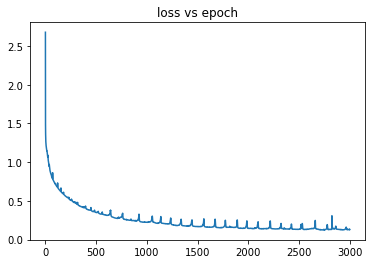

In [298]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(new))], new)
plt.title('loss vs epoch')
plt.show()

In [299]:
print(min(new))

0.125279834476
